In [36]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [37]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [38]:
data = pd.read_csv('cardox.csv')
df = data.copy()
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df = df.set_index('date')
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [39]:
df.shape

(729, 1)

[<AxesSubplot: >]

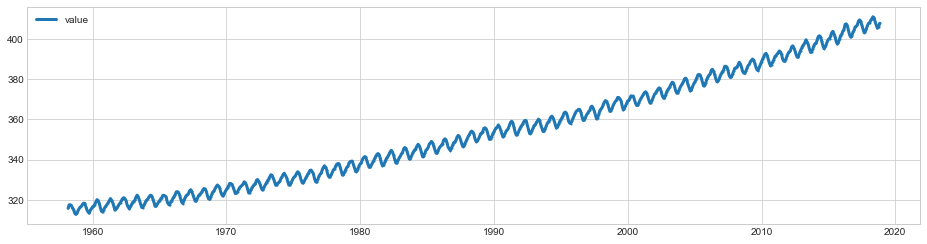

In [40]:
plot(df, ts_linewidth=3)

Text(0.5, 0.98, 'Мультиплікатива модель')

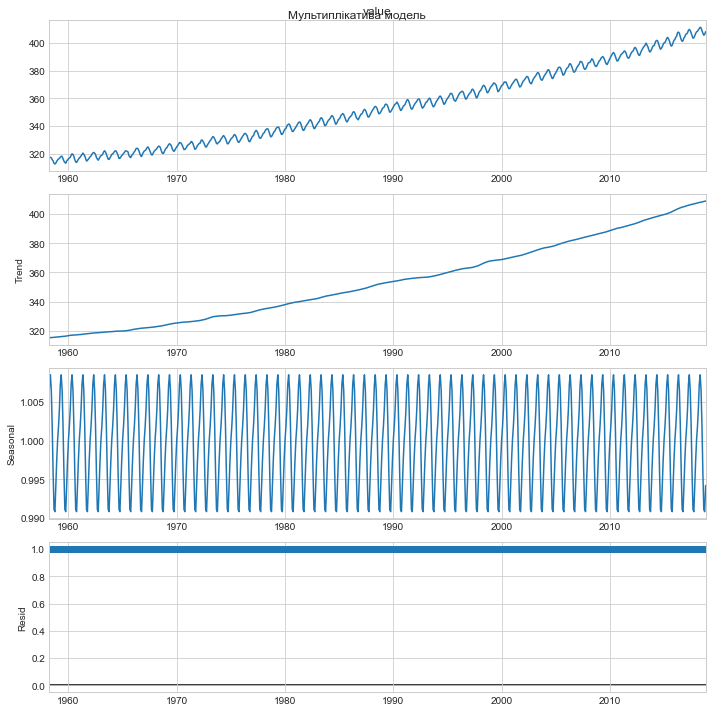

In [41]:
# декомпозиция 
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

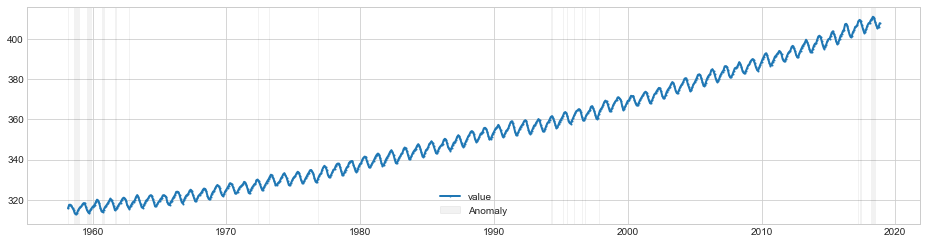

In [42]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='black', anomaly_alpha=0.05, curve_group='all');

In [43]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

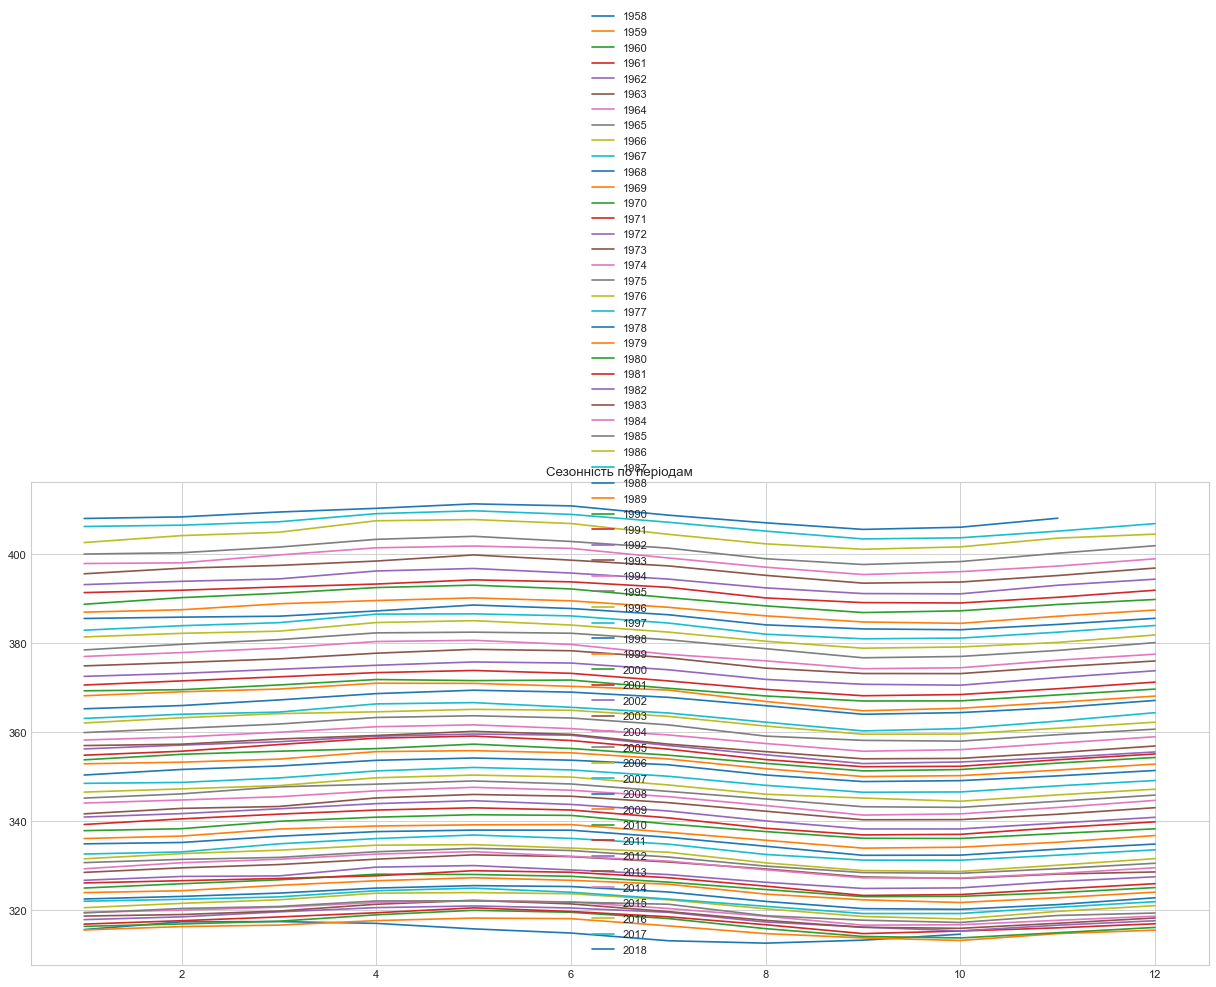

In [44]:
sesonal(df,12)

In [11]:
for i in range (7, anomalies[anomalies].index.size - 7):
    print(df.loc[anomalies[anomalies].index[i]])
    print(df.loc[anomalies[anomalies].index[i] - pd.offsets.DateOffset(years=1)])
    print(df.loc[anomalies[anomalies].index[i] + pd.offsets.DateOffset(years=1)])
    print()
    
    

value    314.8
Name: 1959-08-01 00:00:00, dtype: float64
value    314.93
Name: 1958-08-01 00:00:00, dtype: float64
value    315.91
Name: 1960-08-01 00:00:00, dtype: float64

value    313.84
Name: 1959-09-01 00:00:00, dtype: float64
value    313.2
Name: 1958-09-01 00:00:00, dtype: float64
value    314.16
Name: 1960-09-01 00:00:00, dtype: float64

value    313.26
Name: 1959-10-01 00:00:00, dtype: float64
value    312.66
Name: 1958-10-01 00:00:00, dtype: float64
value    313.83
Name: 1960-10-01 00:00:00, dtype: float64

value    314.8
Name: 1959-11-01 00:00:00, dtype: float64
value    313.33
Name: 1958-11-01 00:00:00, dtype: float64
value    315.0
Name: 1960-11-01 00:00:00, dtype: float64

value    315.58
Name: 1959-12-01 00:00:00, dtype: float64
value    314.67
Name: 1958-12-01 00:00:00, dtype: float64
value    316.19
Name: 1960-12-01 00:00:00, dtype: float64

value    314.16
Name: 1960-09-01 00:00:00, dtype: float64
value    313.84
Name: 1959-09-01 00:00:00, dtype: float64
value    314.

In [12]:
#for i in range (7, anomalies[anomalies].index.size):
    #df.loc[anomalies[anomalies].index[i]] = df.loc[anomalies[anomalies].index[i] - pd.offsets.DateOffset(years=1)]
#df = df.fillna(df.bfill())

Заміна даних з попередніх або наступних періодів не має сенсу, дані +- однакові, що рік назад, що рік в перед

In [14]:
#df2 = df.copy()
#df2['year'] = df2.index.year
#df2['month'] = df2.index.month
#pd.pivot_table(df2, values='value', index='year',columns=['month'], aggfunc=np.sum, fill_value=0)
#for i in range (0, df2.index.size):
 #   print(df2.index[i].year)
  #  print()

In [45]:
train=df['2000':'2005']
train.head()

,value
date,
2000-01-01,369.29
2000-02-01,369.54
2000-03-01,370.60
2000-04-01,371.82
2000-05-01,371.58


In [46]:
test=df['2005':'2010']
test

,value
date,
2005-01-01,378.46
2005-02-01,379.73
2005-03-01,380.77
2005-04-01,382.29
2005-05-01,382.45
...,...
2010-08-01,388.35
2010-09-01,386.85
2010-10-01,387.24


In [47]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

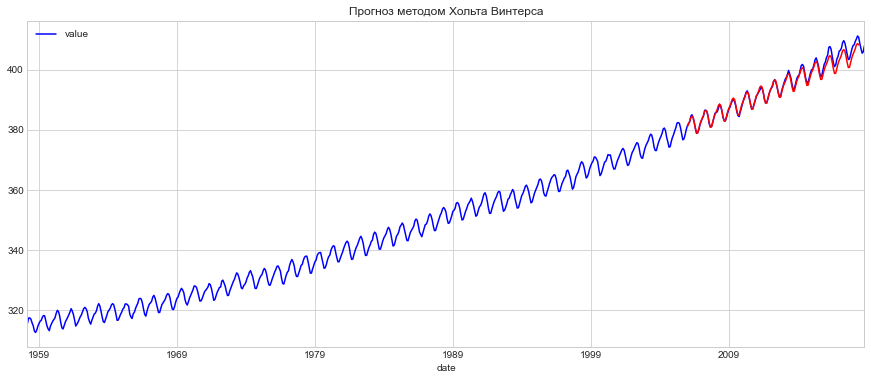

In [48]:
ax = df.plot(figsize=(15,6), color='blue', title="Прогноз методом Хольта Винтерса" )

fit1.forecast(150).plot(ax=ax, style='-', color='red')
plt.show()

In [49]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -5.686
	P-значення = 0.000
Критичне значення :
	1%: -3.526004646825607 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.9032002348069774 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5889948363419957 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 2.1015
MSE: 4.5162
MAPE: 0.0055
MPE: -0.0055
Стандартна похибка: 2.1251


In [51]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=95.969, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=42.430, Time=1.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=262.128, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=46.612, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=39.670, Time=2.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=40.753, Time=2.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=65.881, Time=1.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=39.209, Time=2.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=43.131, Time=1.17 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=40.680, Time=2.53 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=41.285, Time=2.

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

In [52]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 0),
                                seasonal_order=(2, 1, 0, 12))

In [53]:
results = mod.fit()

In [54]:
predict=results.get_prediction(start='2005', end='2019')

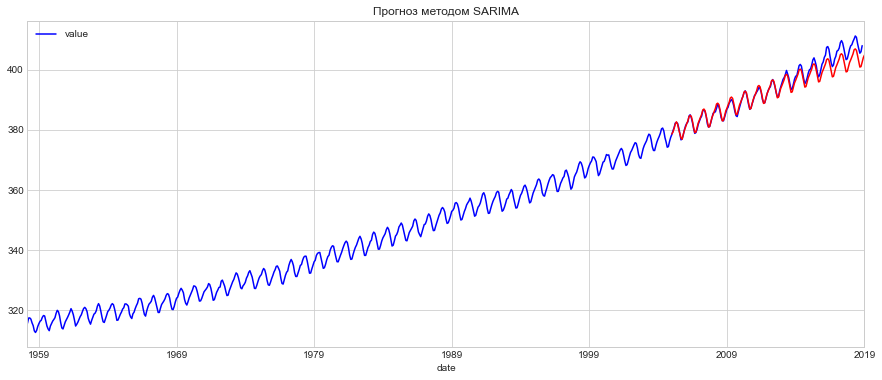

In [55]:
ax = df.plot(figsize=(15,6), color='blue', title="Прогноз методом SARIMA" )
predict.predicted_mean.plot(ax=ax, style='-', color='red')
plt.show()

In [85]:
predict=results.get_prediction(start='2005-01-01', end='2010-01-01')
metrics(test[:-11], predict.predicted_mean)



Тест на стаціонарність:
	T-статистика = -2.190
	P-значення = 0.210
Критичне значення :
	1%: -3.552928203580539 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.9147306250000002 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.595137155612245 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.4329
MSE: 0.2722
MAPE: 0.0011
MPE: -0.0008
Стандартна похибка: 0.5218


In [86]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6752      0.122      5.524      0.000       0.436       0.915
ar.L2          0.3222      0.121      2.655      0.008       0.084       0.560
ar.S.L12      -0.4785      0.140     -3.426      0.001      -0.752      -0.205
ar.S.L24      -0.3690      0.154     -2.395      0.017      -0.671      -0.067
sigma2         0.0918      0.020      4.617      0.000       0.053       0.131


Дві моделі дають хороший решультат прогнозування, 
але метод Хольта Винтерса дає показник P-value менший ніж SARIMA

In [95]:
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()
pred_360 = fit1.forecast(360)

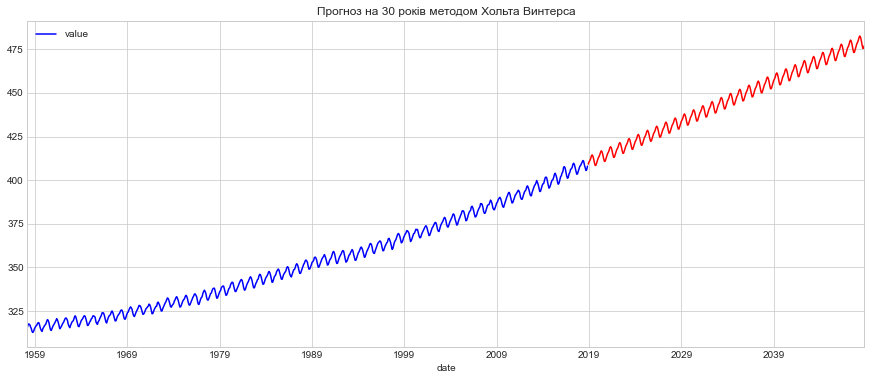

In [96]:
ax = df.plot(figsize=(15,6), color='blue', title="Прогноз на 30 років методом Хольта Винтерса" )
pred_360.plot(ax=ax, style='-', color='red')
plt.show()


In [103]:
pred_360.to_csv('prediction_results.csv')